This notebook explores gaussian processes in GPflow by training one on som generated data. 

First off lets import all the default imports

In [2]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
sns.set(style="darkgrid")
np.random.seed(1)

Now lets generate some data and plot it

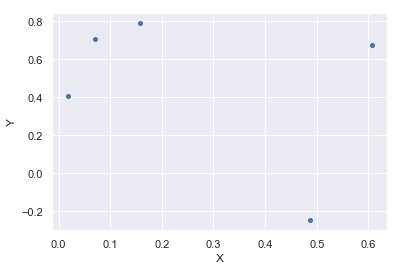

In [34]:
n = 5
X = np.random.rand(n, 1)
Y = np.sin(12 * X) + 0.2 * np.cos(25 * X) + np.random.randn(n,1) * 0.01
df = pd.DataFrame(np.hstack((X, Y)), columns=list('XY'))
sns.scatterplot(x='X', y='Y', data=df)

With that in place we can now build our GPflow model


In [46]:
k = gpflow.kernels.Matern32(1, lengthscales=0.01, variance = 5, ARD=True)
m = gpflow.models.GPR(X, Y, k)
m

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,"(1,)",True,[0.01]
GPR/kern/variance,Parameter,None,+ve,True,(),True,5.0
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,1.0


The code below will learn the parameters using ML

In [48]:
m.compile()
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)
m.as_pandas_table()

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 3.304568
  Number of iterations: 32
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 3.304568
  Number of iterations: 32
  Number of functions evaluations: 51


,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,"(1,)",True,[0.12467581540768821]
GPR/kern/variance,Parameter,None,+ve,True,(),True,0.34013909071833726
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,1.0097092948764746e-06


Lets plot the fit

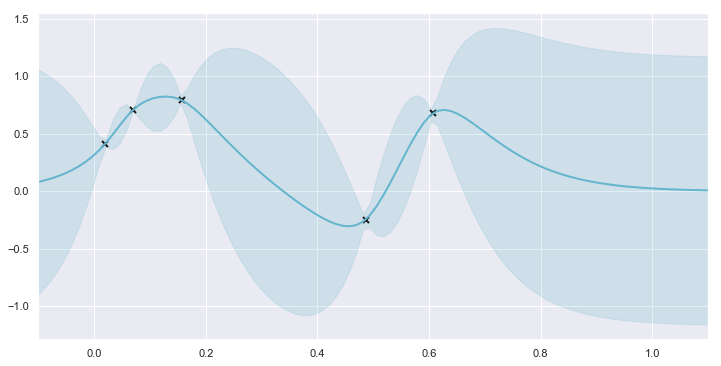

In [49]:
def plot(m, x, y):
    xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)
    mean, var = m.predict_y(xx)
    plt.figure(figsize=(12, 6))
    plt.plot(x, y, 'kx', mew=2)
    plt.plot(xx, mean, 'c', lw=2)
    plt.fill_between(xx[:,0],
                     mean[:,0] - 2*np.sqrt(var[:,0]),
                     mean[:,0] + 2*np.sqrt(var[:,0]),
                     color='C', alpha=0.2)
    plt.xlim(-0.1, 1.1)
    
plot(m, X, Y)

The fit looks pretty neat! Now lets give it the Bayesian treatment and put priors on the hyperparameters.

In [232]:
# Put some very unintelligent priors on our parameters
m.clear()
m.kern.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
m.kern.variance.prior = gpflow.priors.Gamma(1., 1.)
m.likelihood.variance.prior = gpflow.priors.Gamma(1., 1.)
m.compile()
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,"Ga(1.0,1.0)",+ve,True,"(1,)",True,[0.32838005004331416]
GPR/kern/variance,Parameter,"Ga(1.0,1.0)",+ve,True,(),True,3.223060740306471
GPR/likelihood/variance,Parameter,"Ga(1.0,1.0)",+ve,True,(),True,8.228610654438523e-05


We can now use MCMC methods to sample the posterior! Gpflow comes with an HMC (Hamiltonian Monte Carlo, should you wish you search the web for it) so we'll use that. The parameters estimated by MAP will be the starting position of the sampler. The sampling runs on my GPU and takes around a minute, so performance is quite terrible and indicates that the acceptance ratio is very low.


Text(0, 0.5, 'parameter value')

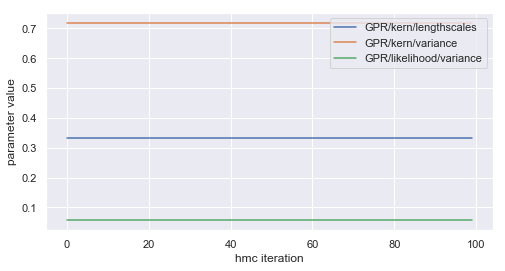

In [245]:
# MAP estimation
o = gpflow.train.AdamOptimizer(0.01)
o.minimize(m, maxiter=15)

sampler = gpflow.train.HMC()
samples = sampler.sample(m, 
                         num_samples=gpflow.test_util.notebook_niter(100), 
                         epsilon=0.15, 
                         lmin=10, 
                         lmax=20, 
                         logprobs=False)

plt.figure(figsize=(8,4))
for i, col in samples.iteritems():
    plt.plot(col, label=col.name)
plt.legend(loc=0)
plt.xlabel('hmc iteration')
plt.ylabel('parameter value')


Plotting the samples show that the Markov chains do not mix at all. It looks like the acceptance ratio is simply 0, and that the HMC hyperparameters or starting position need to be tweaked. 

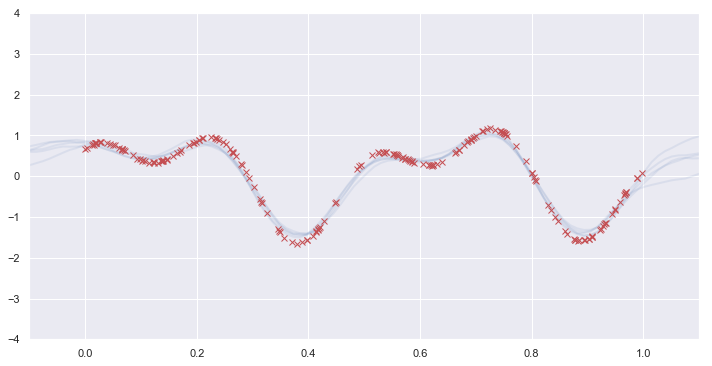

In [246]:
xx = np.linspace(-0.1, 1.1, 100)[:,None]
plt.figure(figsize=(12, 6))
for i, s in samples.iloc[::20].iterrows():
    f = m.predict_f_samples(xx, 1, initialize=False, feed_dict=m.sample_feed_dict(s))
    plt.plot(xx, f[0,:,:], 'C0', lw=2, alpha=0.1)

plt.plot(X, Y, 'rx')
_ = plt.xlim(xx.min(), xx.max())
_ = plt.ylim(-4, 4)

We can not plot histograms of the HMC samples

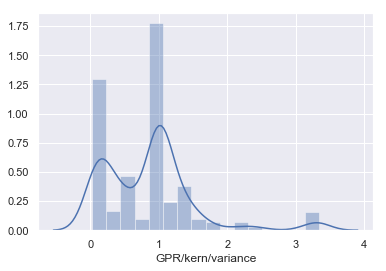

In [135]:
sigma = samples['GPR/kern/variance']
sns.distplot(sigma)

Now lets look at learning a bivariate function insatead. In this case it will be a superposition of two sinusoids.

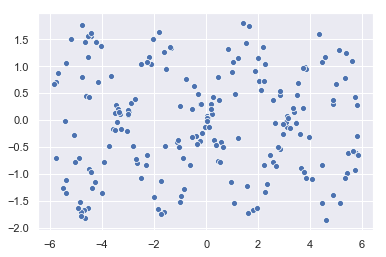

In [140]:
# sample inputs and outputs
n = 200
X = np.random.uniform(-6.,6.,(n,2))
Y = np.sin(X[:,0:1]/2) * 1.8*np.sin(X[:,1:2])+np.random.randn(n,1)*0.05
sns.scatterplot(X[:,1], Y[:,0])

In [141]:
# define kernel
ker = gpflow.kernels.Matern32(2,ARD=True)

# create simple GP model
m = gpflow.models.GPR(X, Y, ker)

# optimize and plot
m.compile()
opt = gpflow.train.ScipyOptimizer()
opt.minimize(m)
m

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -106.015804
  Number of iterations: 19
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -106.015804
  Number of iterations: 19
  Number of functions evaluations: 24


,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,"(2,)",True,"[8.644100104949995, 4.792229307414007]"
GPR/kern/variance,Parameter,None,+ve,True,(),True,3.897632951897702
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,0.001371708586285945


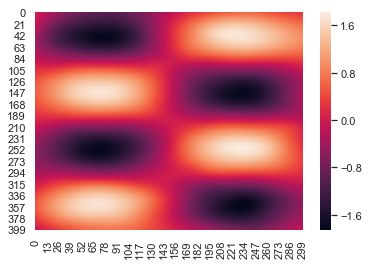

In [142]:
# Plot of posterior mean
xlist = np.linspace(-6.0, 6.0, 300)
ylist = np.linspace(-6.0, 6.0, 400)
xx, yy = np.meshgrid(xlist, ylist)
grid = np.array([np.reshape(xx,(-1,)).T,np.reshape(yy,(-1,))]).T
mean, var = m.predict_y(grid)
sns.heatmap(mean.reshape(400, 300))

As shown above the posterior mean does indeed show the periodic behaviour expected by our function. Very nice!